# **Assignment 3:** Long Short Term Memory (LSTM) for Time Series

#### **Course:** SCC0270-SCC5809 Artificial Neural Networks

#### **Professor:** Moacir Antonelli Ponti

#### **Assistant:** Márcus Vinícius Lobo Costa


---
### **Personal Info:**
*   **Student(s):**
    *   Name and USP Number: Matheus Victal Cerqueira, 10276661

In this assignment you will practice building a LSTM for predicting stock price on the Google Colab environment and with PyTorch. The goals of this practice are the following:

- Understand how to set up a time-series prediction problem for neural networks
- Implement a LSTM-based network to solve such problem
- Experiment with different LSTM architectures

# **1. Dataset**


We will be using a dataset IBM stock price.

## **Preparing Task:** Upload your IBM stock price dataset

Upload your file `ibm.us.txt` into the cell bellow.

In [1]:
# you can upload the file using the following code, or manually
from google import colab as cl

file_upload = cl.files.upload()

Saving ibm.us.txt to ibm.us (1).txt


In [2]:
import pandas as pd

dataset = pd.read_csv('/content/ibm.us.txt', index_col='Date', parse_dates=True,
                      usecols=['Date', 'Close'], na_values=['nan'])

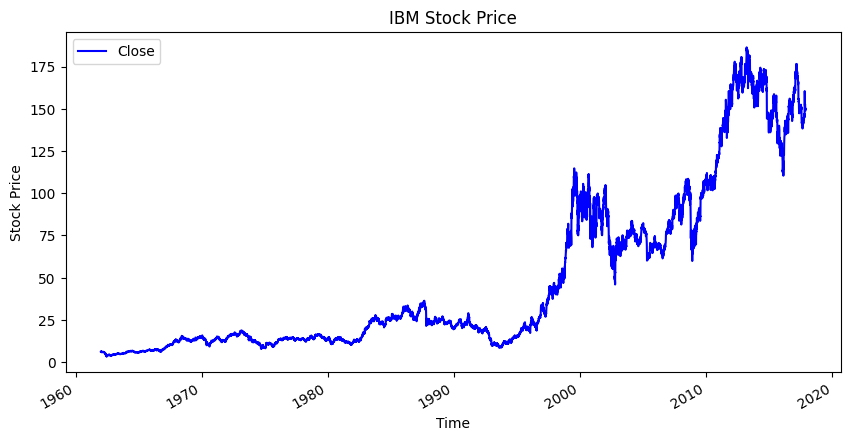

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

dataset.plot(figsize=(10, 5), color = 'blue')
plt.title("IBM Stock Price")
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.show()

### Time series interval:

- For this assignment, we will only be using the years 2010 to 2017 for stock prices.

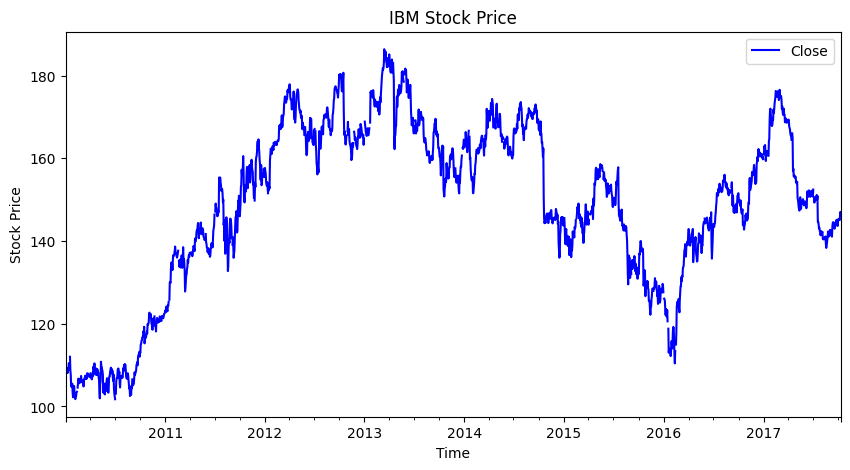

In [4]:
dates = pd.date_range('2010-01-04','2017-10-11', freq='B')
df = pd.DataFrame(index=dates)
dataset = df.join(dataset)

dataset[['Close']].plot(figsize=(10, 5), color = 'blue')
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("IBM Stock Price")
plt.show()

In [5]:
dataset.head()

,Close
2010-01-04,110.59
2010-01-05,109.26
2010-01-06,108.56
2010-01-07,108.19
2010-01-08,109.26


**Feature Scaling**

Transform features by scaling each feature to a given range. Here we are scaling it to the interval -1 to 1.

The sklearn MinMaxScaler is a moethod for scaling variables. Its documentation can verified at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [6]:
from sklearn.preprocessing import MinMaxScaler

dataset = dataset.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['Close'] = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))

In [7]:
#Processed data
print(dataset.head())

               Close
2010-01-04 -0.790830
2010-01-05 -0.822264
2010-01-06 -0.838809
2010-01-07 -0.847554
2010-01-08 -0.822264


In [8]:
print(dataset.shape)

(2028, 1)


**Create Datasets**

Preparing ou dataset for `training` and `validation` sets.

The datasets are defined as "sliding window" points, so that each time series subinterval is used to predict a point in the future.

For example we can use the values of 7 days to predict the value of the 8th day. In this case we have a lookback of 8.


In [9]:
import torch
import numpy as np
from torchsummary import summary

def create_split_data(ts, lookback, test_split_size):
  """ Function to create a supervised dataset from time series
      Parameters:
      ts : list or Series with time series values
      lookback : defines how many points backwards
                 so that the lookback-1 points are going
                 to be used to predict the next one
      test_split_size : value between 0-1 defining the
                        proportion of the series to use as test set
  """

  data_raw = ts.to_numpy() #Convert to numpy array
  data = []

  # create all possible sequences of length equal to lookback
  for index in range(len(data_raw) - lookback):
      # each observation t will contain the 'lookback' previous points
      data.append(data_raw[index: index + lookback])

  data = np.array(data)

  # compute training and testing sizes
  test_set_size = int(np.round(test_split_size*data.shape[0]))
  train_set_size = data.shape[0] - (test_set_size)

  # arrays for recurrent nets have 3 dimensions:
  # - number of samples (for training, testing)
  # - number of time steps (defined by the lookback parameter)
  # - number of features (for a single time series, this will be 1)

  # the x and y will have a displacement so that
  # each point from 0 to t-1 is used to predict the point t
  x_train = data[:train_set_size, :-1, :]
  y_train = data[:train_set_size, -1, :]

  x_test = data[train_set_size:, :-1, :]
  y_test = data[train_set_size:, -1, :]

  # Converts into Pytorch tensors
  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train = torch.from_numpy(y_train).type(torch.Tensor)
  y_test = torch.from_numpy(y_test).type(torch.Tensor)

  return [x_train, y_train, x_test, y_test]

### **Task 1:** (0.5 pts) Use the provided function to define the training and testing datasets with lookback of 30 days and 20% of the time series for testing

In [12]:
# The function recieves as parameters the dataset, the lookback value and the size (proportion) of the test dataset.
X_train, y_train, X_test, y_test = create_split_data(ts=dataset, lookback=30, test_split_size=.2)

# **2. Building our LSTM Model**

### **Architecture Review**

- `Long Short Term Memory networks` – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png"
     alt="LSTM Chain"
     style="float: left; margin-right: 10px; width:100px; height: 100px;" />

### Network Definition

Study the base code for the class below. See that the forward pass is a little different from other networks, since we want to backpropagate only the current values in the sequence. Also in both training and inference times, initializing these states at each forward pass ensures that the model starts fresh for each new sequence it processes and updates the states according to the information in the sequence only. This allows the model to learn and retain information over time as it processes sequential data.

### **Task 2:** (1.5 pt)

1. Complete the class with the required code so that we have an LSTM network with:
- At least one layer `num_layers = 1`, with the number of LSTM units (`hidden_size`) fixed for all layers
- A linear output layer (the output value will be used as the predicted value)
- Allow the number of layers and number of dimensions to be defined at the moment of network initialization (you can use just a single LSTM for that since the `hidden_size` will be equal for all layers and pytorch allows to stack layers in a single `nn.LSTM()` call)

2. Initialize one network using input and output dimensions = 1, then 1 layer with 32 LSTM units. Print the resulting model.

In [13]:
import torch.nn as nn

#Reference LSTM pytorch: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# Class LSTM_base inherits nn.Module, as stated bellow. The nn.Module is the
# basic class for Neural Networks made with pytorch. Its documentation can be
# verified in https://pytorch.org/docs/stable/generated/torch.nn.Module.html.
class LSTM_base(nn.Module):

  # The __init__ dunder method receives self (object), the input dimension,
  # the LSTM hidden_size (number of features in the hidden state h, which can be
  # found on the LSTM diagram above), the number of layers for the LSTM (number
  # of stacked LSTM modules that will be defined on the nn.LSTM call) and the
  # output dimension, witch corresponds to the linear layer output dimension.
  def __init__(self, input_dim, hidden_size, num_layers, output_dim):
    super(LSTM_base, self).__init__()

    # Defining the hidden size and number of layers class attributes
    self.hidden_size = hidden_size  #Hidden dimensions
    self.num_layers = num_layers  #Number of hidden layers

    # Defining the network layers:

    # The LSTM layer is the first layer of the network, so it receives the
    # initial input. The parameter batch_first was set to "True" so the tensor
    # is provided on the dimension (batch, seq, feature) instead of
    # (seq, batch, feature).
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # The linear layer receives the output from the LSTM layer (hence, the h
    # from the last stacked LSTM)
    self.fc = nn.Linear(in_features=hidden_size, out_features=output_dim)

  # The foward function is defined in a way
  def forward(self, x):
    # Initialize hidden state with zeros
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #hidden state
    # Initialize cell state
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #cell state

    # h0 and c0 are memory states and are not supposed to be learned (no
    # gradient computation), hence, they need to be detached. (Discussion:
    # https://stackoverflow.com/questions/66187443/lstm-detach-the-hidden-state)
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

    # get as output only the hidden layer of the last stage
    out = self.fc(out[:, -1, :])

    return out

In [14]:
## instantiate the model and print it

# As required in the exercise, the parameters are input_dim=1, hidden_size=32,
# num_layers=1, output_dim=1. The number of layers was chosen as 1 because on
# the last exercise we will study in more detail the behavior of stacked LSTM
# layers.
model = LSTM_base(input_dim=1, hidden_size=32, num_layers=1, output_dim=1)

In [15]:
print(model)

LSTM_base(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


# **3.Training**

### **Task 3:** (3 pts) Training the LSTM model

Study the base function below, and complete with the required code. The function first trains the model, and then predict the values for a testing dataset.

Use the MSE Loss and the Adam optimizer with an initial learning rate of 0.005, and run a training for 50 epochs.

In [16]:
def training_and_evaluate(model, epochs, loss_function, optimizer, X_train, y_train, X_test, verbose=True):
  """Function to train a model and evaluate it
     Params:
      model - instantiated model
      epochs - number of epochs
      loss_function - loss function object (torch) to train the model
      optimizer - optimizer object (torch) to train the model
      X_train, y_train - training dataset
      X_test - testing dataset
      verbose - Flag to allow print the loss at each epoch (default = True)
    Returns:
      history of the training, predictions for training, predictions for testing
      ex: history, y_pred_train, y_pred_test
  """

  # The variable history_train is used to store the loss for each epoch
  history_train = np.zeros(epochs)

  # Set model in training mode
  model.train()

  # The model will be trained using one batch, hence, there is only one for loop
  # in the trainning procedure.
  for epoch in range(epochs):

    #Forward pass
    y_pred = model.forward(X_train)

    #Loss function/criterion
    loss = loss_function(y_pred, y_train)

    # The verbose mode prints the training information.
    if verbose:
        print(f"Epoch [{epoch + 1}|{epochs}] Loss: {loss.item()}")

    # Include the loss for the current epoch on the history train array.
    history_train[epoch] = loss.item()

    #Clean the gradient
    optimizer.zero_grad()

    #Update parameters
    loss.backward()
    optimizer.step()

  # Set model validation mode
  model.eval()

  # Disable gradient calculation. This is useful for inference steps.
  # Doc.: (https://pytorch.org/docs/stable/generated/torch.no_grad.html)
  with torch.no_grad():
    # Make predictions for the training and testing datasets
    y_pred_train = model.forward(X_train)
    y_pred_test = model.forward(X_test)

  # Returns the losses by epoch array, the predicted values for the trainning
  # set and the prediction values for the test set
  return history_train, y_pred_train, y_pred_test


<br>
<br>
<br>

For good practices purposes, the original dataset will be again obtained. The model will be also instantiated again. This maintains the instantiation and the function calls close in the code for debbuging.

In [17]:
X_train, y_train, X_test, y_test = create_split_data(ts=dataset, lookback=30, test_split_size=.2)

In [18]:
model = LSTM_base(input_dim=1, hidden_size=32, num_layers=1, output_dim=1)

In [19]:
print(model)

LSTM_base(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [20]:
# specify training parameters and functions

# MSE Loss critetion
loss_function = nn.MSELoss()

# Adam optimizer with lr=.005
optimizer = torch.optim.Adam(model.parameters(), lr=.005)

In [21]:
# use `training_and_evaluate` function
history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                 epochs=50,
                                                                 loss_function=loss_function,
                                                                 optimizer=optimizer,
                                                                 X_train=X_train,
                                                                 y_train=y_train,
                                                                 X_test=X_test,
                                                                 verbose=True)

Epoch [1|50] Loss: 0.27368995547294617
Epoch [2|50] Loss: 0.2529994249343872
Epoch [3|50] Loss: 0.2351919263601303
Epoch [4|50] Loss: 0.21826794743537903
Epoch [5|50] Loss: 0.19976530969142914
Epoch [6|50] Loss: 0.17824922502040863
Epoch [7|50] Loss: 0.1532084047794342
Epoch [8|50] Loss: 0.12437834590673447
Epoch [9|50] Loss: 0.09183445572853088
Epoch [10|50] Loss: 0.05884859338402748
Epoch [11|50] Loss: 0.04257645085453987
Epoch [12|50] Loss: 0.03102881647646427
Epoch [13|50] Loss: 0.04301643744111061
Epoch [14|50] Loss: 0.044548168778419495
Epoch [15|50] Loss: 0.03832802176475525
Epoch [16|50] Loss: 0.029117178171873093
Epoch [17|50] Loss: 0.017832648009061813
Epoch [18|50] Loss: 0.011496276594698429
Epoch [19|50] Loss: 0.010111614130437374
Epoch [20|50] Loss: 0.010945798829197884
Epoch [21|50] Loss: 0.01212586835026741
Epoch [22|50] Loss: 0.012739669531583786
Epoch [23|50] Loss: 0.012438302859663963
Epoch [24|50] Loss: 0.011286511085927486
Epoch [25|50] Loss: 0.00976101029664278
Epo

#4. **Evaluating and Visualizing the Results**

Study the function `model_performance` below, completing the parts needed for:
- using the scaler to inverse transform the predicted training and testing series
- computing the root of the mean squared error for the training predicted data, and the testing predicted data
- visualize the

### **Task 4:** (2 pt) Visualize the results as follows:
- Plot the training history (the loss values along epochs)
- Use the function `model_performance` to plot the Root Mean Squared Error Values for both training and testing sets, as weel as plotting the test time series actual values and the predicted values.

In [22]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

def model_performance(y_train, y_hat_train, y_test, y_hat_test):
    """Visualize series and predicted series, and evaluate model with RMSE
       Params:
          y_train - real training series
          y_hat_train - predicted training series
          y_test - real testing series
          y_hat_test - predicted training series
    """
    # Apply the reverse transformation on the data
    y_train_rev = scaler.inverse_transform(y_train.detach().numpy()).tolist()
    y_hat_train_rev = scaler.inverse_transform(y_hat_train.detach().numpy()).tolist()
    y_test_rev = scaler.inverse_transform(y_test.detach().numpy()).tolist()
    y_hat_test_rev = scaler.inverse_transform(y_hat_test.detach().numpy()).tolist()

    # Calculates and prints the root mean squared error (RMSE)

    train_RMSE = math.sqrt(mean_squared_error(y_train_rev, y_hat_train_rev))
    test_RMSE = math.sqrt(mean_squared_error(y_test_rev, y_hat_test_rev))

    print('Train score: {result} RMSE'.format(result=train_RMSE))
    print('Test score: {result} RMSE'.format(result=test_RMSE))

    # plot the curves of the Testing series, both real and predited

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.set(style="whitegrid")

    # List treatment to turn lists of lists to single list. Then, values are
    # inserted in a pandas df.
    df_lines = pd.DataFrame({'Actual Price': [value for sublist in y_test_rev for value in sublist],
                             'Predicted Price': [value for sublist in y_hat_test_rev for value in sublist]})
    sns.lineplot(data=df_lines,
                 palette={'Actual Price': 'indigo', 'Predicted Price': 'deeppink'},
                 linewidth=1.5)

    plt.title('Stock Price Prediction', fontsize=16)
    plt.xlabel('Time indicator (test set)', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.show()


Train score: 2.882025259071296 RMSE
Test score: 2.203044765337626 RMSE


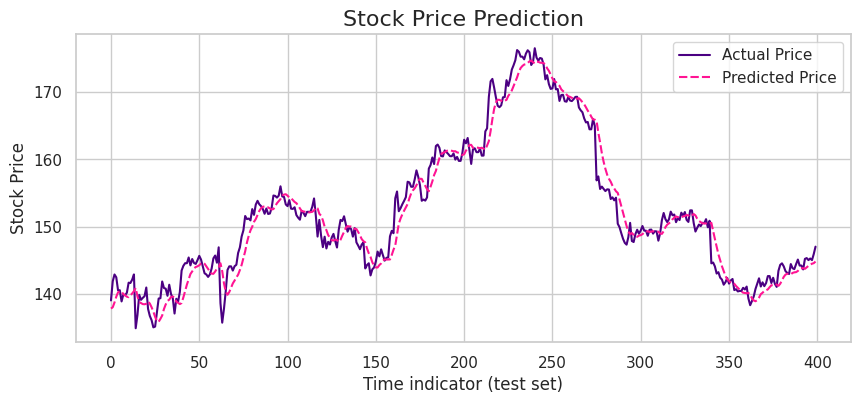

In [26]:
model_performance(y_train, y_pred_train, y_test, y_pred_test)

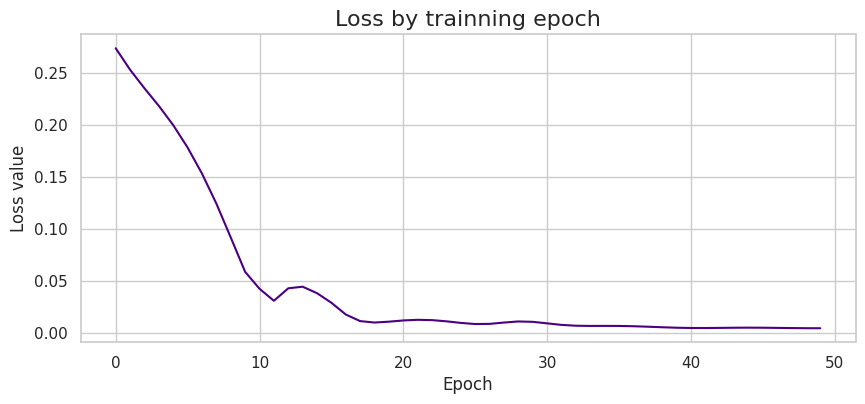

In [27]:
figure, axes = plt.subplots(figsize=(10, 4))
plt.plot(history_train, color = 'indigo')
plt.title('Loss by trainning epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss value', fontsize=12)
plt.show()

# 5 **Experiments**



## **Task 5** (3 pts) using as basis the implemented model, perform an experiment as follows:

1. Change the optimization function to `AdamW` and the loss function to MAE (mean absolute error), which is implemented in torch by the `L1Loss` class. In all experiments use 30 epochs and Learning Rate = 0.0025

2. Execute experiments with the following architectural configurations:
- 1 Hidden Layer, 4 LSTM units
- 1 Hidden Layer, 16 LSTM units
- 1 Hidden Layer, 32 LSTM units
- 3 Hidden Layers, 4 LSTM units
- 3 Hidden Layers, 16 LSTM units
- 3 Hidden Layers, 32 LSTM units

3. From the experiments, draw some conclusions about the varying architectural configurations (in the end of the notebook)

To obtain more experimental data, more configuration setups were included. Hence, the tested configurations were:
- 1 Hidden Layer, 4 LSTM units
- 1 Hidden Layer, 16 LSTM units
- 1 Hidden Layer, 32 LSTM units
- 1 Hidden Layer, 64 LSTM units
- 3 Hidden Layers, 4 LSTM units
- 3 Hidden Layers, 16 LSTM units
- 3 Hidden Layers, 32 LSTM units
- 3 Hidden Layer, 64 LSTM units
- 4 Hidden Layers, 4 LSTM units
- 4 Hidden Layers, 16 LSTM units
- 4 Hidden Layers, 32 LSTM units
- 4 Hidden Layer, 64 LSTM units


In the code cell bellow, a list named "config" is instantiated and it contains all combinations of the configurations in question. Each instance of the list is a tuple and its first value corresponds to the number of hidden layers and the second value to the LSTM units.
The results and conclusions are presented bellow.

In [28]:
input_dim = 1
output_dim = 1

configs = [[1,4],
           [1,16],
           [1,32],
           [1,64],
           [3,4],
           [3,16],
           [3,32],
           [3,64],
           [4,4],
           [4,16],
           [4,32],
           [4,64]]

In [29]:
X_train, y_train, X_test, y_test = create_split_data(ts=dataset, lookback=30, test_split_size=.2)








Hidden Layers: 1
LSTM units: 4

Train score: 22.712844128957556 RMSE
Test score: 15.133486904239767 RMSE


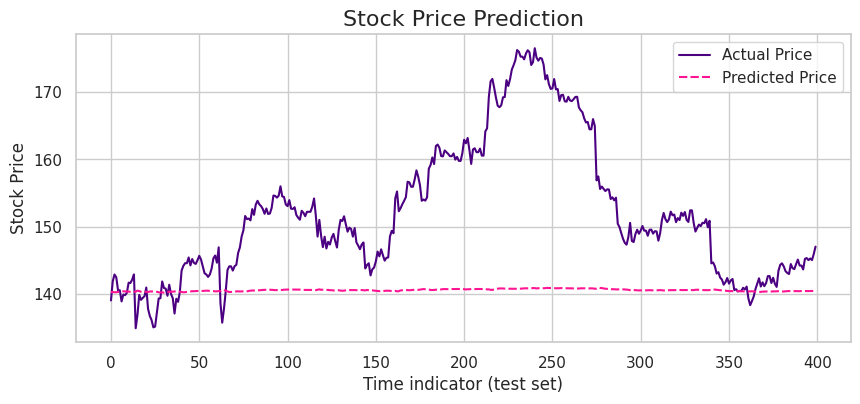

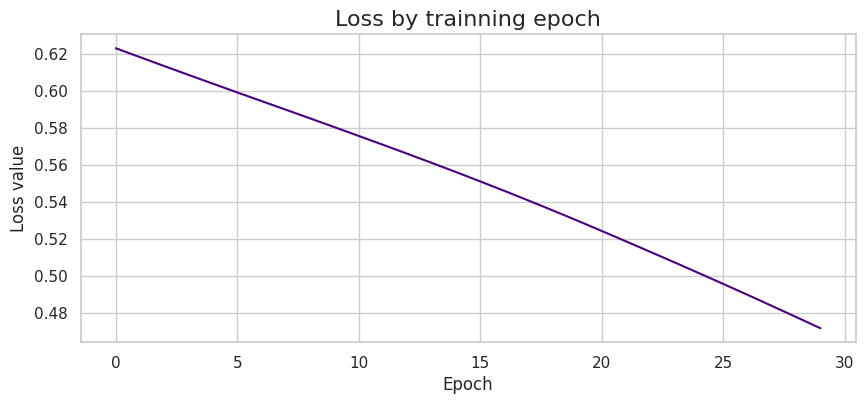








Hidden Layers: 1
LSTM units: 16

Train score: 12.404407672134088 RMSE
Test score: 6.649435259475596 RMSE


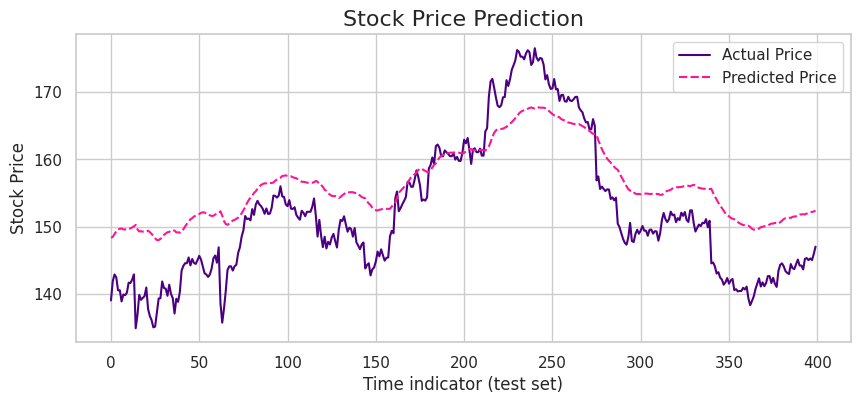

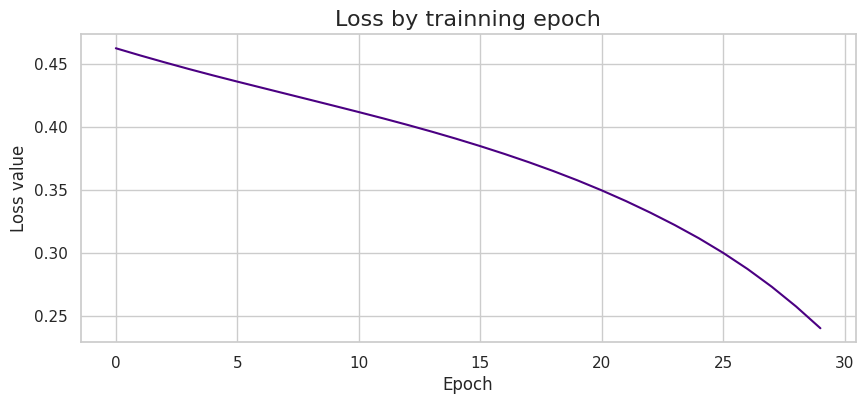








Hidden Layers: 1
LSTM units: 32

Train score: 8.242673881492168 RMSE
Test score: 6.455614530038094 RMSE


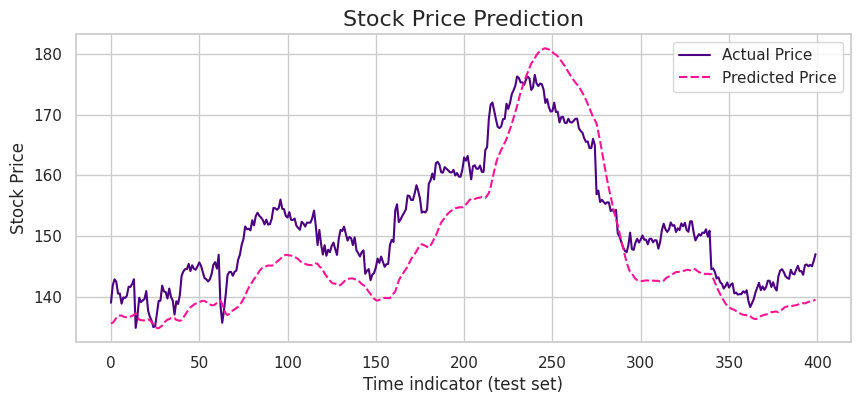

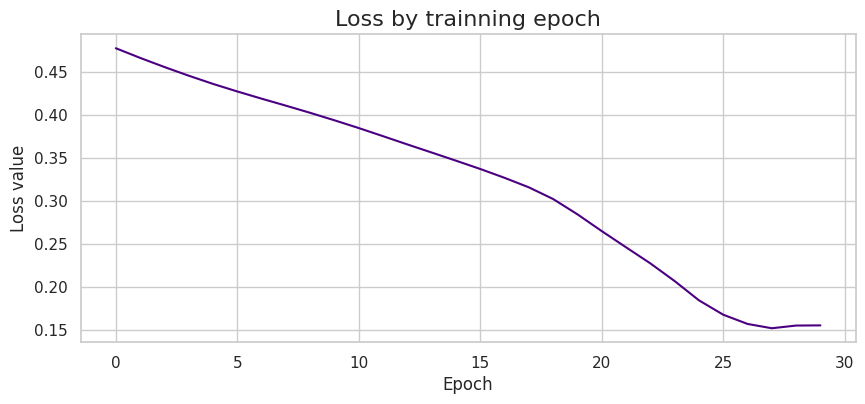








Hidden Layers: 1
LSTM units: 64

Train score: 4.000158529001355 RMSE
Test score: 2.7831711977939624 RMSE


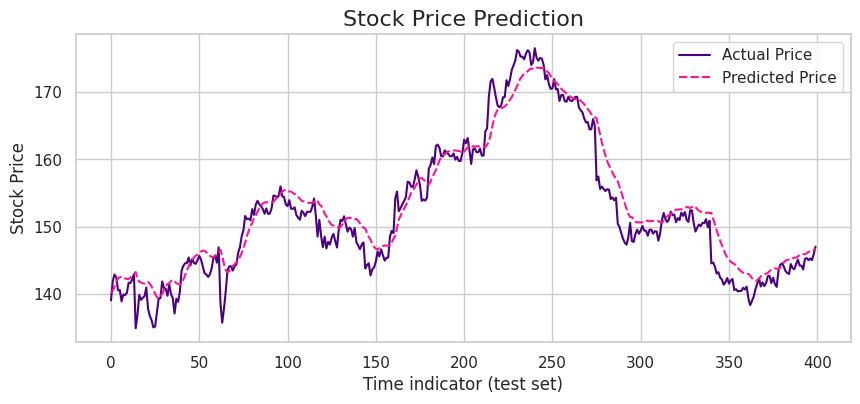

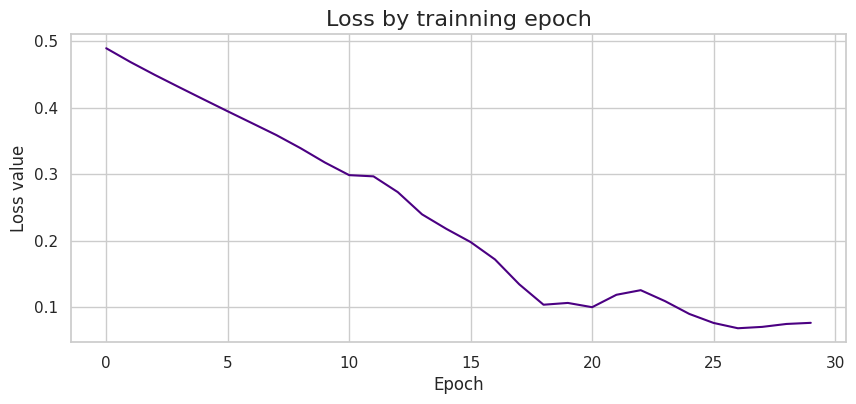








Hidden Layers: 3
LSTM units: 4

Train score: 22.382103567462572 RMSE
Test score: 13.678943056192692 RMSE


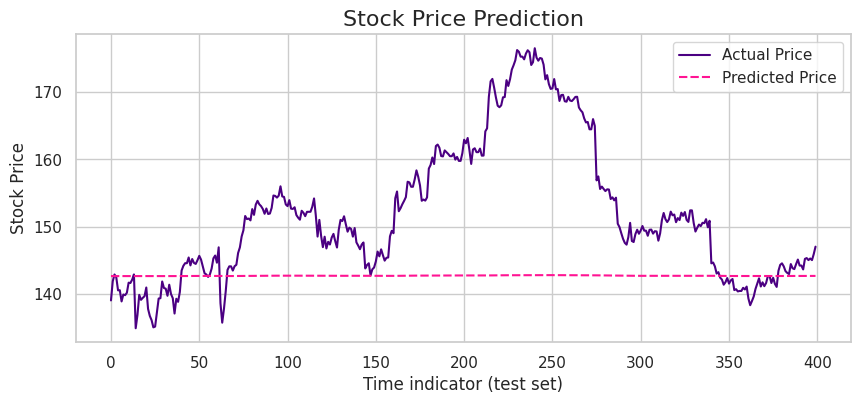

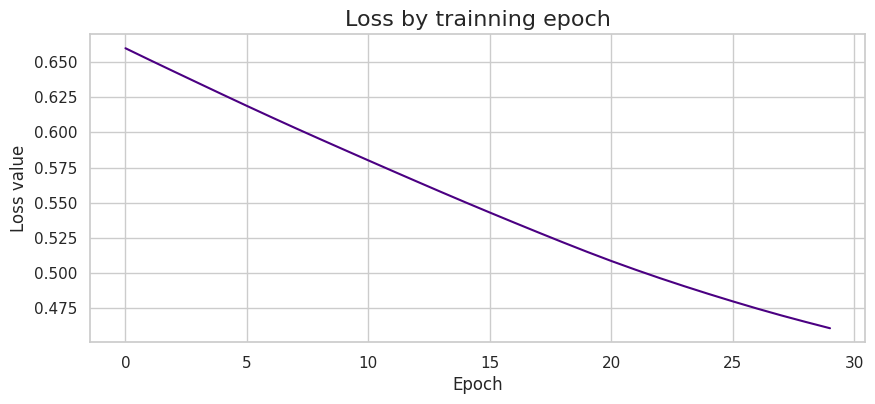








Hidden Layers: 3
LSTM units: 16

Train score: 9.137061369282408 RMSE
Test score: 10.659829902783791 RMSE


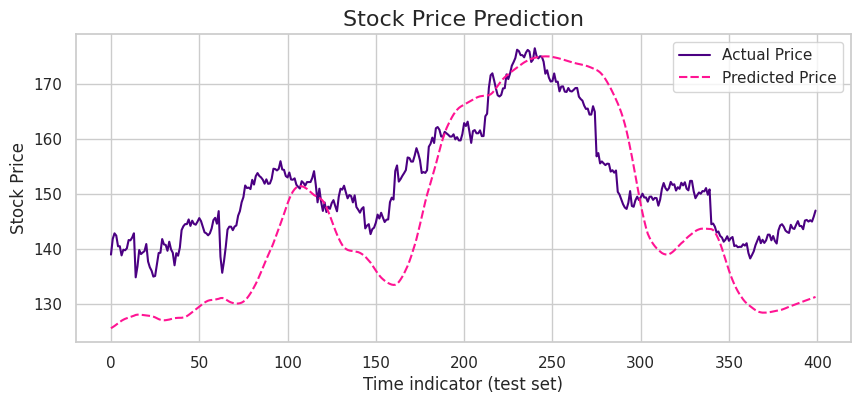

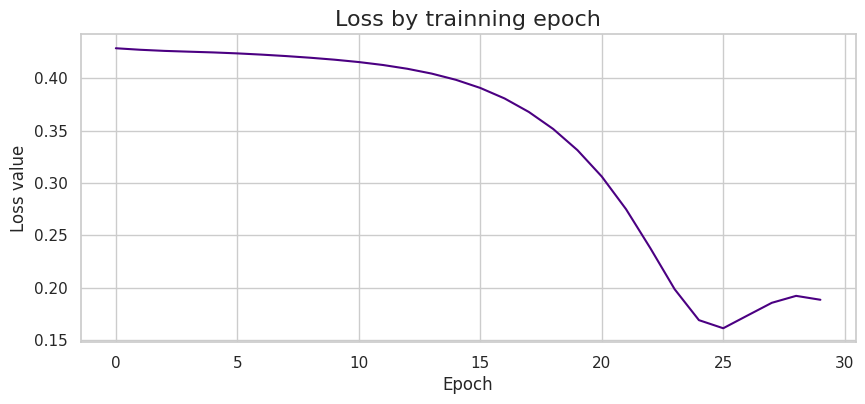








Hidden Layers: 3
LSTM units: 32

Train score: 5.29187978591803 RMSE
Test score: 5.209082637138928 RMSE


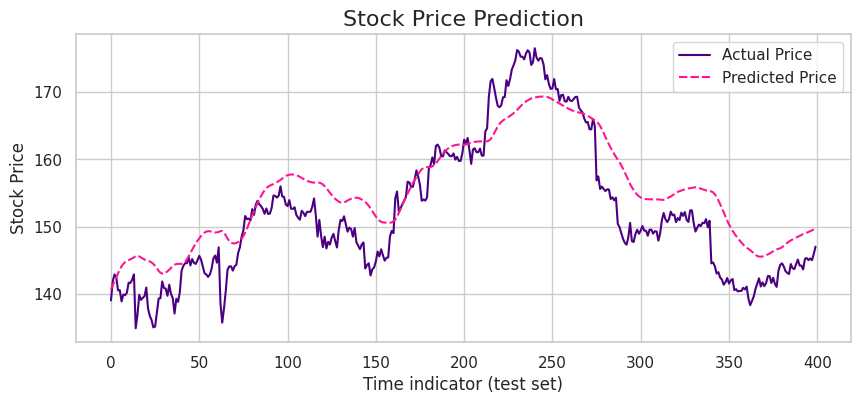

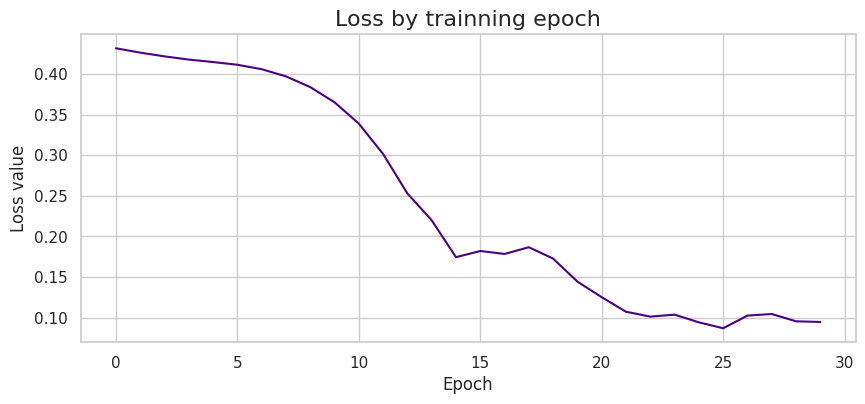








Hidden Layers: 3
LSTM units: 64

Train score: 3.9627780307853016 RMSE
Test score: 3.3663578211322926 RMSE


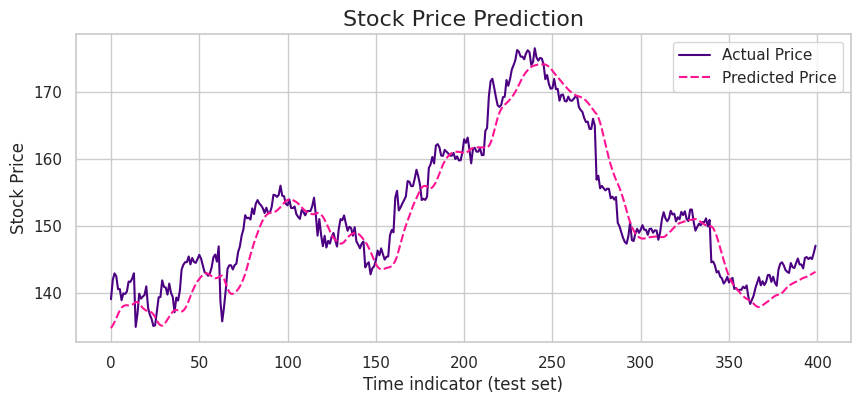

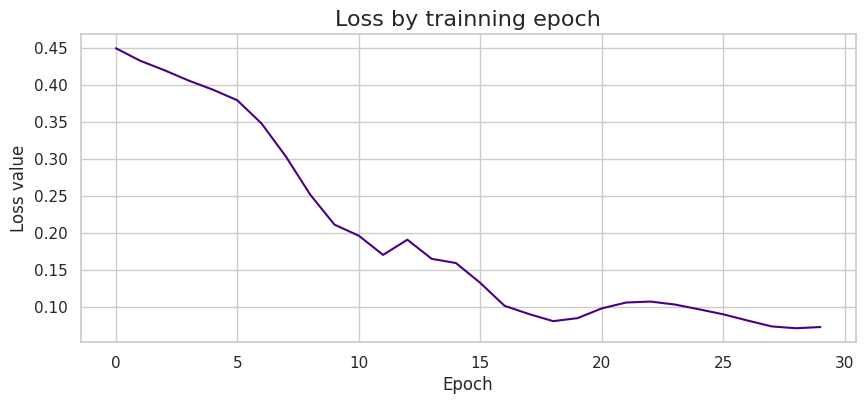








Hidden Layers: 4
LSTM units: 4

Train score: 22.076581507881578 RMSE
Test score: 10.27851717559451 RMSE


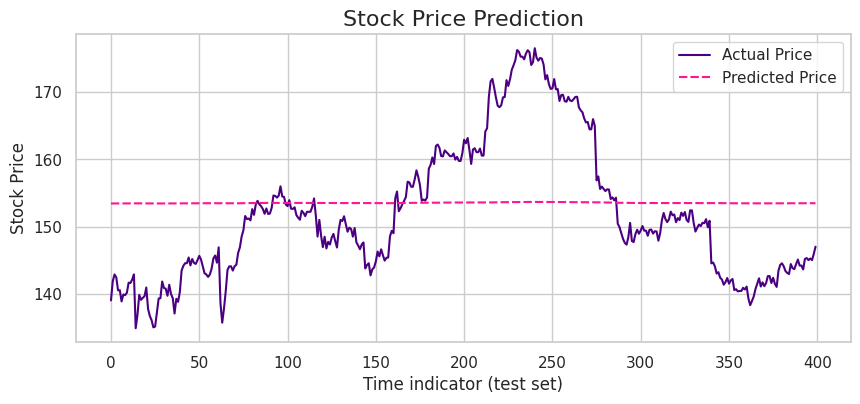

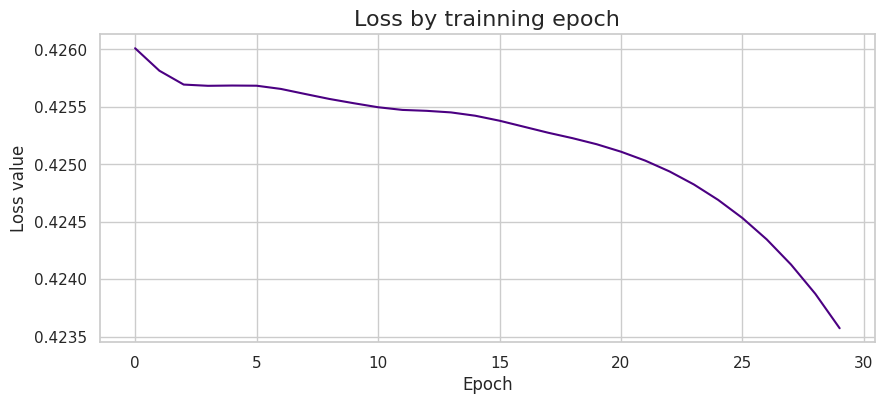








Hidden Layers: 4
LSTM units: 16

Train score: 12.48628102139835 RMSE
Test score: 5.372748605132246 RMSE


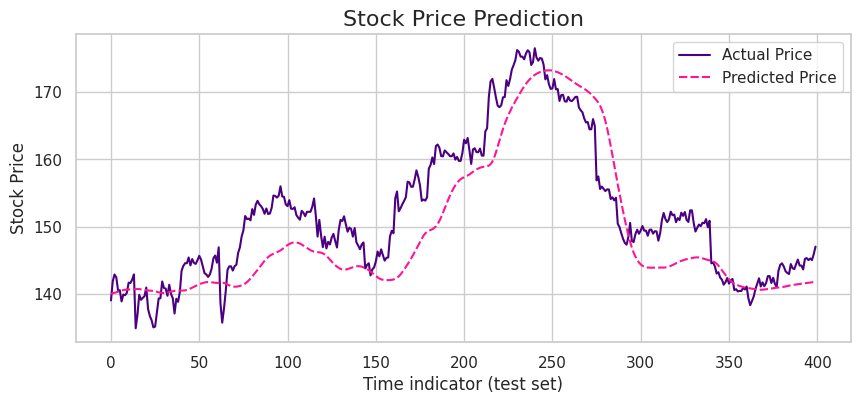

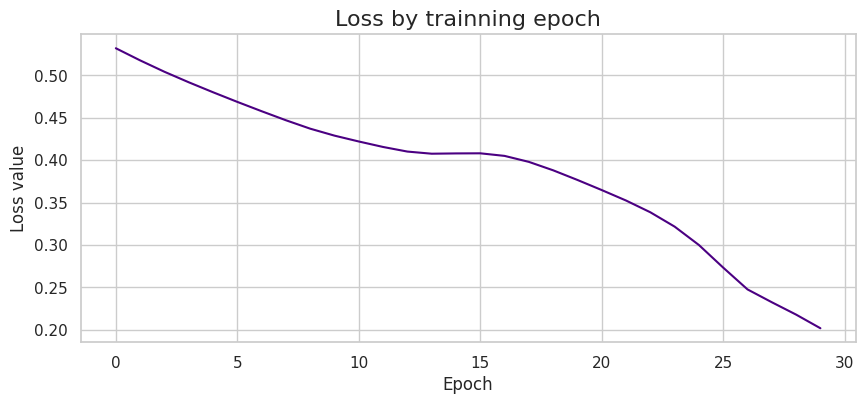








Hidden Layers: 4
LSTM units: 32

Train score: 5.888706615094667 RMSE
Test score: 5.138644044151097 RMSE


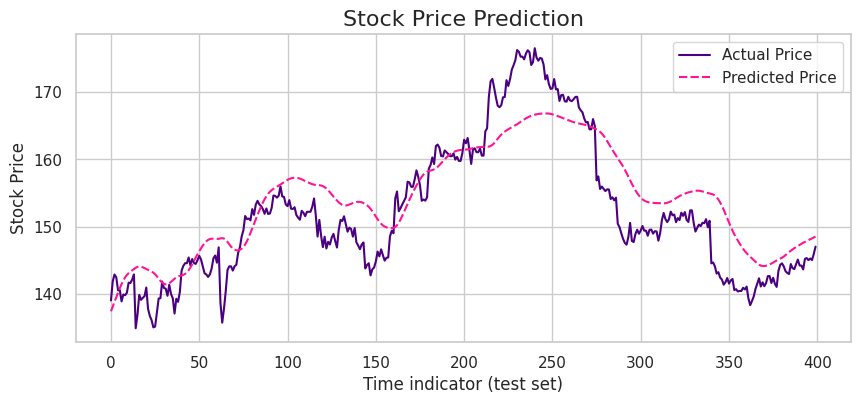

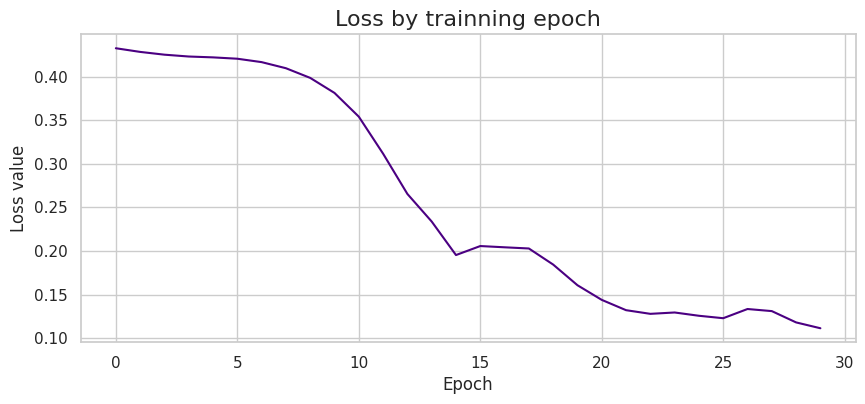








Hidden Layers: 4
LSTM units: 64

Train score: 4.657749277343589 RMSE
Test score: 4.089258896848894 RMSE


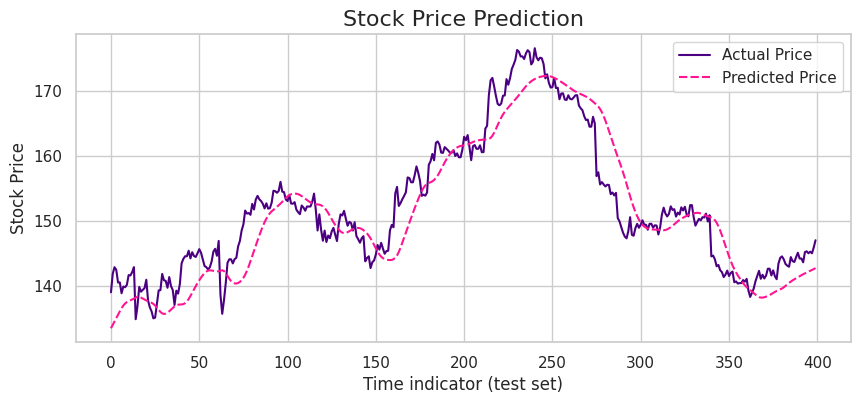

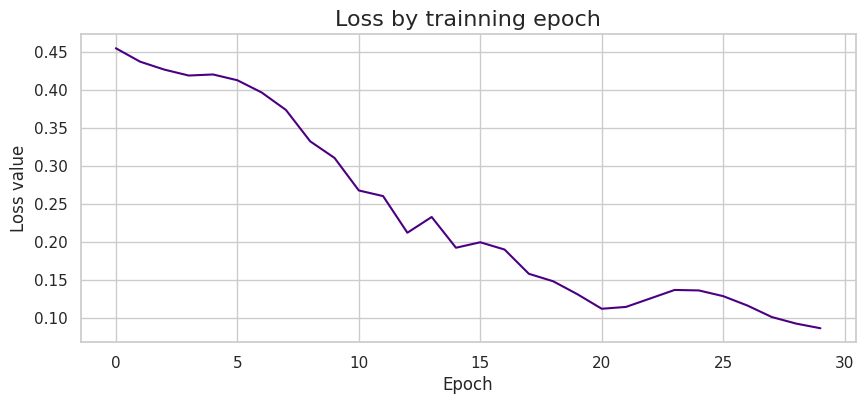

In [31]:
for hidden_layers, lstm_units in configs:

    # Model instantiation
    model = LSTM_base(input_dim=input_dim, hidden_size=lstm_units, num_layers=hidden_layers, output_dim=output_dim)

    # MAE Loss critetion
    loss_function = nn.L1Loss()
    # AdamW optimizer with lr=.0025
    optimizer = torch.optim.AdamW(model.parameters(), lr=.0025)

    # Training the model
    history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                     epochs=30,
                                                                     loss_function=loss_function,
                                                                     optimizer=optimizer,
                                                                     X_train=X_train,
                                                                     y_train=y_train,
                                                                     X_test=X_test,
                                                                     verbose=False)

    print('\n\n\n\n\n\n\nHidden Layers: {hidden_layers}'.format(hidden_layers=hidden_layers))
    print('LSTM units: {lstm_units}\n'.format(lstm_units=lstm_units))
    model_performance(y_train, y_pred_train, y_test, y_pred_test)

    figure, axes = plt.subplots(figsize=(10, 4))
    plt.plot(history_train, color = 'indigo')
    plt.title('Loss by trainning epoch', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss value', fontsize=12)
    plt.show()

### **Conclusions/Remarks** from the experiment results

In the experiments performed above, each graph double (predicted vs real values graphic and loss over epoch graphic) and printed RMSE values represents the results for one configuration. Several conclusions can be made based on these results:

- It is noticeable in the experiments that for a given number of layers, the increase of the number of LSTM units tends to lead to a greater performance to some extent. However, increasing this hypermarameter indefinitely can lead to overfitting and this is not a general rule.

- The same is not always observable when we set a given number of LSTM units and increase the layers of the model: for a given LSTM units number, increaing the layers did not always translated to better perfoemance considering the experiments. This can be noticed as the RMSE (both in the training an test sets) is larger for the 4 layers 64 LSTM units configuration when compared to the 3 layers 64 LSTM units configuration. It is also noticeable that the shalower model (1 layer) with 64 LSTM units is the one that better performed on the test set. Increasing the depth of the network leads to a model with more layers of abstraction and greater complexity. This is not always translated to better performance, it can be pottentialy translated to overfitting. Hence, sometimes the simpler model can be the one with better performance, as seen in this experiments.
-> 1 layer 64 LSTM units - Train score: 4.00 RMSE Test score: 2.78 RMSE
-> 3 layers 64 LSTM units - Train score: 3.96 RMSE Test score: 3.37 RMSE
-> 4 layers 64 LSTM units - Train score: 4.66 RMSE Test score: 4.09 RMSE

- Models with 4 LSTM units performed extremely bad, as they are to simple to capture the time series pattern. They barely learned any pattern on the data and predicted almost constant values over time for the test set.

- The loss over epochs behavior of models with more LSTM units are more unstable and have more ups and downs than in models with less LSTM units. This serves to ilustrate how it can be difficult to find an optima on a model with more parameters to optimize and sometimes the backpropagation and optimization can go on the "wrong direction", returning to a state on the parameter hyperplan that leads to a bigger result loss.

- Lets focus our attention in the case of the models with one layer. It is noticeable how the prediction is slowly adhering to the real values as we increase the LSTM units. In the case of the model with 64 LSTM units it captured the general trend of the time series. More experiments with more LSTM units could be made to verify the moment where overffiting starts to take place.

- There was only one model where the train RMSE was lower than the test RMSE: the one with 3 Hidden Layers and 16 LSTM units. This does not necessarily configures an overffiting phenomena but is worth of noting.

- For this given problem, the best performnce on the test set was achieved by the model with 1 layer 64 LSTM units. Hence, one layer is probably enough to capture the behavior of the time series in question.